In [1]:
import time
import numpy as np
import os
from scipy.io import wavfile

# sklearn
from sklearn import neighbors
from sklearn.metrics import confusion_matrix

# visualization
import matplotlib.pyplot as plt
import seaborn
from tqdm.notebook import tqdm

# torch
import torch
from torch import nn
import torch.nn.functional as F

# Dataset
from torch.utils.data import DataLoader, Dataset

#Sklearn
from sklearn.model_selection import train_test_split

import copy

from torch.utils.data import random_split

##### AudioDataset class

In [2]:
sliced_dataset = "../data/short_audio_dataset"
sliced_dataset_lenght = 16050
original_dataset = "../data/audio_dataset"
original_dataset_lenght = 80249

class AudioDataset(Dataset):
    def __init__(self, drop_both=False):
        root_folder = original_dataset
        max_length = original_dataset_lenght
        self.class_map = {"esben" : 0, "peter": 1, "both": 2}
        self.data = []
        self.wavs = []
        self.labels = []
        for subdir, dirs, files in os.walk(root_folder):
            for file_name in files:
                if "both" in subdir and drop_both:
                   continue
                file_path = os.path.join(subdir, file_name)
                _, wav = wavfile.read(file_path)
                wav = wav.astype(np.float32)
                if wav.shape[0] > max_length:
                    max_length = wav.shape[0]
                    print("Found wav with more length than specified max one, new max is:", wav.shape[0])
                wav = np.pad(wav, (0, max_length-wav.shape[0]))
                label_str = file_path.split('/')[3][2:]
                label = (np.int64(self.class_map[label_str]))
                self.wavs.append(wav)
                self.labels.append(label)
                self.data.append([wav, label])
        print("Max length of wav files:", max_length)
    

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        wav = self.wavs[idx]
        class_id = self.labels[idx]
        # class_id = self.class_map[label]
        wav_tensor = torch.from_numpy(wav)
        class_id = torch.tensor(class_id)
        return wav_tensor, class_id


### Data generation

In [3]:
dataset = AudioDataset(drop_both=True)
print(len(dataset.data))
train_data, val_data, test_data = random_split (dataset, [150, 30, 20])
print(len(train_data), len(val_data), len(test_data))
train_loader = DataLoader(train_data, batch_size=5, shuffle=True)
valid_loader = DataLoader(val_data, batch_size=5, shuffle=True)
test_loader = DataLoader(test_data, batch_size=5, shuffle=True)
#for x, y in train_loader:
#    print(x.shape, y.shape)
#    break


Max length of wav files: 80249
200
150 30 20


# MLP
* Build a Multi Layer Perceptron, MLP, with one ReLU-activated hidden layer.
* Use the validation set to inform e.g. number of hidden neurons.
* When you're satisfied, then, use the test set to get an  
unbiased estimate of your models performance on the real data distribution.

In [4]:
# by extending nn.Module:
class MLP(nn.Module):
  def __init__(self, n_hidden_neurons: int):
    super().__init__()
    self.fc1 = nn.Linear(original_dataset_lenght, n_hidden_neurons)
    self.fc2 = nn.Linear(n_hidden_neurons, 2)

  def forward(self, x: torch.Tensor):
    # print(self.fc1.weight, self.fc1.bias, x)
    # print(type(self.fc1.weight), type(self.fc1.bias), type(x))
    # print("here")
    # x = x.flatten(start_dim=0)  # (N, d_data)
    h = F.relu(self.fc1(x))
    logits = self.fc2(h)
    return logits

In [5]:
all_losses, all_accuracies = {}, {}
best_accuracy = 0
best_model = None

In [6]:
device = torch.device('cuda')
for n_hidden_neurons in (10, 100, 1000):
  model = MLP(n_hidden_neurons)
  opt = torch.optim.SGD(model.parameters(), lr=5e-2)

  train_losses, train_accuracies = [], []
  valid_losses, valid_accuracies = [], []

  for epoch in range(10):
    print(epoch, end='\r')
    # train
    epoch_losses = []
    correct, total = 0, 0
    for x, y in train_loader:
      #print(x.shape)
      #print(y.shape)
      opt.zero_grad()
      # x, y = torch.tensor(x), torch.tensor(y)
      logits = model(x)  # logits: common name for the output before softmax activation
      #print(logits.shape)
      log_probs = F.log_softmax(logits, dim=1)  # numerically stable version of log(softmax(logits))
      #print(log_probs.shape)
      loss = F.nll_loss(log_probs, y)  # negative log likelihood loss
      # or just: loss = F.cross_entropy(logits, y)
      print(loss)

      loss.backward()
      opt.step()

      epoch_losses.append(loss.item())
      total += len(x)
      correct += (torch.argmax(logits, dim=1) == y).sum().item()
    train_losses.append(np.mean(epoch_losses))
    train_accuracies.append(correct / total)
    for x, y in valid_loader:
      #x, y = x.to(device), y.to(device)
      
      # Performance tip: we don't want to update weights
      # based on the validation set, so we don't need
      # pytorch to keep track of gradients here
      with torch.no_grad():
        logits = model(x)
      loss = F.cross_entropy(logits, y)

      epoch_losses.append(loss.item())
      total += len(x)
      correct += (torch.argmax(logits, dim=1) == y).sum().item()
    valid_losses.append(np.mean(epoch_losses))
    valid_accuracy = correct / total
    valid_accuracies.append(valid_accuracy)

    if valid_accuracy > best_accuracy:
      best_accuracy = valid_accuracy
      best_model = copy.deepcopy(model), n_hidden_neurons, epoch

  all_losses[n_hidden_neurons] = train_losses, valid_losses
  all_accuracies[n_hidden_neurons] = train_accuracies, valid_accuracies

tensor(0., grad_fn=<NllLossBackward0>)
tensor(186.3705, grad_fn=<NllLossBackward0>)
tensor(2.0512e+08, grad_fn=<NllLossBackward0>)
tensor(5.5453e+13, grad_fn=<NllLossBackward0>)
tensor(5.6501e+19, grad_fn=<NllLossBackward0>)
tensor(0., grad_fn=<NllLossBackward0>)
tensor(7.0661e+25, grad_fn=<NllLossBackward0>)
tensor(3.6007e+30, grad_fn=<NllLossBackward0>)
tensor(2.6079e+35, grad_fn=<NllLossBackward0>)
tensor(nan, grad_fn=<NllLossBackward0>)
tensor(nan, grad_fn=<NllLossBackward0>)
tensor(nan, grad_fn=<NllLossBackward0>)
tensor(nan, grad_fn=<NllLossBackward0>)
tensor(nan, grad_fn=<NllLossBackward0>)
tensor(nan, grad_fn=<NllLossBackward0>)
tensor(nan, grad_fn=<NllLossBackward0>)
tensor(nan, grad_fn=<NllLossBackward0>)
tensor(nan, grad_fn=<NllLossBackward0>)
tensor(nan, grad_fn=<NllLossBackward0>)
tensor(nan, grad_fn=<NllLossBackward0>)
tensor(nan, grad_fn=<NllLossBackward0>)
tensor(nan, grad_fn=<NllLossBackward0>)
tensor(nan, grad_fn=<NllLossBackward0>)
tensor(nan, grad_fn=<NllLossBackwar

In [7]:
print (all_losses)
print (train_losses)
print (all_accuracies)

{10: ([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 100: ([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 1000: ([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])}
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
{10: ([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], [0.4888888888888889, 0.4888888888888889, 0.4888888888888889, 0.4888888888888889, 0.4888888888888889, 0.4888888888888889, 0.4888888888888889, 0.4888888888888889, 0.4888888888888889, 0.4888888888888889]), 100: ([0.5333333333333333, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], [0.5166666666666667, 0.4888888888888889, 0.4888888888888889, 0.4888888888888889, 0.4888888888888889, 0.4888888888888889, 0.4888888888888889, 0.4888888888888889, 0.4888888888888889, 0.4888888888888889]), 1000: ([0.5133333333333333, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], [0.5

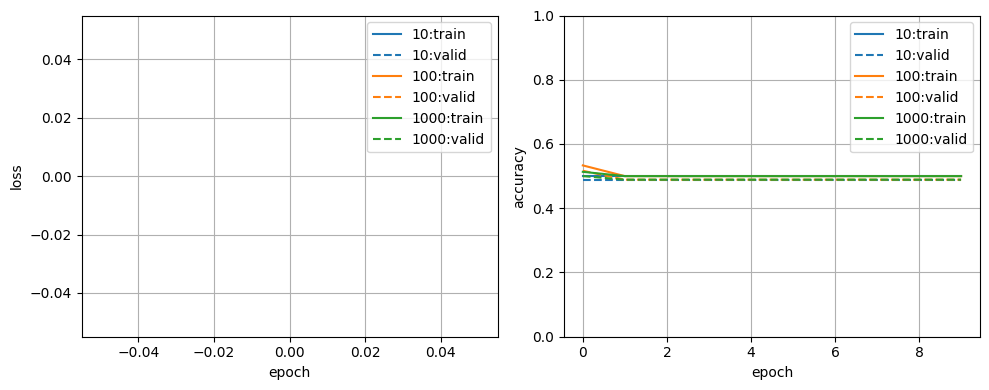

In [8]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.xlabel('epoch')
plt.ylabel('loss')
for n, (train_losses, valid_losses) in all_losses.items():
  p = plt.plot(train_losses, label=f'{n}:train')
  plt.plot(valid_losses, label=f'{n}:valid', ls='--', c=p[0].get_color())
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
for n, (train_accuracies, valid_accuracies) in all_accuracies.items():
  p = plt.plot(train_accuracies, label=f'{n}:train')
  plt.plot(valid_accuracies, label=f'{n}:valid', ls='--', c=p[0].get_color())
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [9]:
# test
model, n_hidden_neurons, epoch = best_model
print(f'best val accuracy: {best_accuracy:.2f} with {n_hidden_neurons} hidden neurons after {epoch} epoch')

correct, total = 0, 0
for x, y in valid_loader:
  x, y = x.to(device), y.to(device)
  with torch.no_grad():
    logits = model(x)
  total += len(x)
  correct += (torch.argmax(logits, dim=1) == y).sum().item()
print(f'test accuracy: {correct / total:.2f}')

best val accuracy: 0.52 with 100 hidden neurons after 0 epoch


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)